# Problem Set #5
MACS 30150, Dr. Evans  
Minghao Yang

## 1. Some income data, lognormal distribution, and GMM (7 points)
### (a)

In [1]:
# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import numpy as np
import numpy.linalg as lin
import scipy.integrate as intgr

In [2]:
# Load the data as a NumPy array
incomes_1 = np.loadtxt('data/incomes.txt')

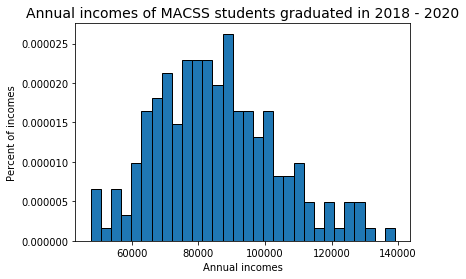

In [3]:
# Draw the histogram (normed=True is replaced by density=True to avoid warning)
num_bins = 30
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.show()

### (b)

In [4]:
# Define a function returning the mean and s.d. of the data
def data_moments_1_bc(xvals):
    
    mean_data = xvals.mean()
    sd_data = xvals.std()
    
    return mean_data, sd_data

In [5]:
# Define a function returning the mean and s.d. calculated from the model
# To avoid the slow intgr.quad, I use formulas to calculate the mean and variance of the lognormal distribution
def model_moments_1_bc(mu, sigma):
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    sd_model = np.sqrt((np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2))
    
    return mean_model, sd_model

In [6]:
# Define a function returning the error vector
def err_vec_1_bc(xvals, mu, sigma, simple=False):
    mean_data, sd_data = data_moments_1_bc(xvals)
    moms_data = np.array([mean_data, sd_data])
    mean_model, sd_model = model_moments_1_bc(mu, sigma)
    moms_model = np.array([mean_model, sd_model])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [7]:
# Define the criterion function
def criterion_1_bc(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec_1_bc(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [8]:
# GMM estimation and result report
mu_init_1_b = 11
sig_init_1_b = 0.5
params_init_1_b = np.array([mu_init_1_b, sig_init_1_b])
W_hat_1_b = np.eye(2)
gmm_args_1_b = (incomes_1, W_hat_1_b)
results_1_b = opt.minimize(criterion_1_bc, params_init_1_b, args=(gmm_args_1_b),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_b, sig_GMM_1_b = results_1_b.x
crit_val_GMM_1_b = results_1_b.fun
mean_data_1_bc, sd_data_1_bc = data_moments_1_bc(incomes_1)
mean_model_GMM_1_b, sd_model_GMM_1_b = model_moments_1_bc(mu_GMM_1_b, sig_GMM_1_b)

print('The GMM estimation of mu is', mu_GMM_1_b)
print('The GMM estimation of sigma is', sig_GMM_1_b)
print('The value of the criterion function at GMM estimates is', crit_val_GMM_1_b)
print('The mean of the data is', mean_data_1_bc)
print('The mean of the model is', mean_model_GMM_1_b)
print('The difference between the means is', abs(mean_data_1_bc - mean_model_GMM_1_b))
print('The percent difference between the means is', abs(mean_data_1_bc - mean_model_GMM_1_b) / mean_data_1_bc)
print('The standard deviation of the data is', sd_data_1_bc)
print('The standard deviation of the model is', sd_model_GMM_1_b)
print('The difference between the standard deviations is', abs(sd_data_1_bc - sd_model_GMM_1_b))
print('The percent difference between the standard deviations is', abs(sd_data_1_bc - sd_model_GMM_1_b) / sd_data_1_bc)

The GMM estimation of mu is 11.331880866982898
The GMM estimation of sigma is 0.20869665246828492
The value of the criterion function at GMM estimates is 1.005186460950373e-15
The mean of the data is 85276.82360625811
The mean of the model is 85276.82542230906
The difference between the means is 0.0018160509498557076
The percent difference between the means is 2.1295949744104155e-08
The standard deviation of the data is 17992.542128046523
The standard deviation of the model is 17992.541705444266
The difference between the standard deviations is 0.0004226022574584931
The percent difference between the standard deviations is 2.3487634735046507e-08


We can see that the means and standard deviations of the data and the model are similar.

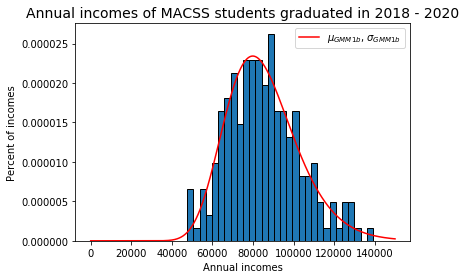

In [9]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_b, scale=np.exp(mu_GMM_1_b)),
        label='$\mu_{GMM1b}$, $\sigma_{GMM1b}$', color='r')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

### (c)

In [10]:
# Define a function returning the error matrix
# To make the error matrix and error vector consistent, I modify Dr. Evans' code so that the difference is 
# calculated by moments of model minus data instead of by moments of data minus model if simple and by moments of
# model minus data over moments of data instead of by moments of data minus model over moments of model if not simple
def get_Err_mat_1_c(pts, mu, sigma, simple=False):

    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, sd_model = model_moments_1_bc(mu, sigma)
    if simple:
        Err_mat[0, :] = mean_model - pts
        Err_mat[1, :] = sd_model - np.sqrt((pts.mean() - pts) ** 2)
    else:
        Err_mat[0, :] = (mean_model - pts) / pts
        Err_mat[1, :] = (sd_model - np.sqrt((pts.mean() - pts) ** 2)) / np.sqrt((pts.mean() - pts) ** 2)
    
    return Err_mat

In [11]:
# Generate the error matrix and report it
Err_mat_1_c = get_Err_mat_1_c(incomes_1, mu_GMM_1_b, sig_GMM_1_b)
VCV_1_c = (1 / incomes_1.shape[0]) * (Err_mat_1_c @ Err_mat_1_c.T)
print('The variance covariance matrix from part (b) is\n', VCV_1_c)
W_hat_1_c = lin.inv(VCV_1_c)
print('The two-step weighting matrix is\n', W_hat_1_c)

The variance covariance matrix from part (b) is
 [[5.30804094e-02 6.35000837e-03]
 [6.35000837e-03 1.32826953e+04]]
The two-step weighting matrix is
 [[ 1.88393433e+01 -9.00645430e-06]
 [-9.00645430e-06  7.52859293e-05]]


In [12]:
# Two-step GMM estimation and result report
mu_init_1_c = 11
sig_init_1_c = 0.5
params_init_1_c = np.array([mu_init_1_c, sig_init_1_c])
gmm_args_1_c = (incomes_1, W_hat_1_c)
results_1_c = opt.minimize(criterion_1_bc, params_init_1_c, args=(gmm_args_1_c),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_c, sig_GMM_1_c = results_1_c.x
crit_val_GMM_1_c = results_1_c.fun
mean_model_GMM_1_c, sd_model_GMM_1_c = model_moments_1_bc(mu_GMM_1_c, sig_GMM_1_c)

print('The two-step GMM estimation of mu is', mu_GMM_1_c)
print('The two-step GMM estimation of sigma is', sig_GMM_1_c)
print('The value of the criterion function at two-step GMM estimates is', crit_val_GMM_1_c)
print('The mean of the data is', mean_data_1_bc)
print('The mean of the model (two-step) is', mean_model_GMM_1_c)
print('The difference between the means (two-step) is', abs(mean_data_1_bc - mean_model_GMM_1_c))
print('The percent difference between the means (two-step) is', abs(mean_data_1_bc - mean_model_GMM_1_c) / mean_data_1_bc)
print('The standard deviation of the data is', sd_data_1_bc)
print('The standard deviation of the model (two-step) is', sd_model_GMM_1_c)
print('The difference between the standard deviations (two-step) is', abs(sd_data_1_bc - sd_model_GMM_1_c))
print('The percent difference between the standard deviations (two-step) is',
      abs(sd_data_1_bc - sd_model_GMM_1_c) / sd_data_1_bc)

The two-step GMM estimation of mu is 11.331879161215275
The two-step GMM estimation of sigma is 0.2087047197809695
The value of the criterion function at two-step GMM estimates is 1.1722872189891404e-13
The mean of the data is 85276.82360625811
The mean of the model (two-step) is 85276.82353650316
The difference between the means (two-step) is 6.975495489314198e-05
The percent difference between the means (two-step) is 8.179825648199092e-10
The standard deviation of the data is 17992.542128046523
The standard deviation of the model (two-step) is 17993.252078772803
The difference between the standard deviations (two-step) is 0.7099507262792031
The percent difference between the standard deviations (two-step) is 3.9458055522490164e-05


Compared with the results in part (b), the two-step GMM estimation yields a more precise model mean, but gives a less precise model standard deviation. In addition, the criterion function value in two-step GMM is even larger, so the two-step GMM does not perform much better. 

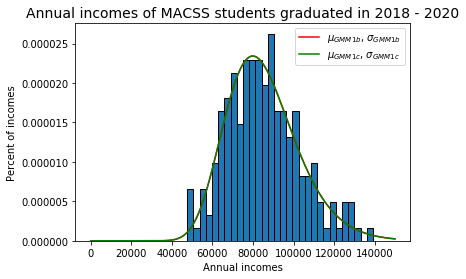

In [13]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_b, scale=np.exp(mu_GMM_1_b)),
        label='$\mu_{GMM1b}$, $\sigma_{GMM1b}$', color='r')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_c, scale=np.exp(mu_GMM_1_c)),
        label='$\mu_{GMM1c}$, $\sigma_{GMM1c}$', color='g')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

The two lognormal distributions are highly identical, so the green distribution almost cover the red one completely. 

### (d)

In [14]:
# Define a function returning the percentiles of the data
def data_moments_1_de(xvals):
    
    bpct_1_data = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_data = xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] / xvals.shape[0]
    bpct_3_data = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    
    return bpct_1_data, bpct_2_data, bpct_3_data

In [15]:
# Define a function returning the percentiles calculated from the model
# (To avoid the slow intgr.quad, I use sts.lognorm.cdf to calculate percents directly)
def model_moments_1_de(mu, sigma):
    
    bpct_1_model = sts.lognorm.cdf(75000, s=sigma, scale=np.exp(mu))
    bpct_2_model = sts.lognorm.cdf(100000, s=sigma, scale=np.exp(mu)) - bpct_1_model
    bpct_3_model = 1 - bpct_1_model - bpct_2_model
    
    return bpct_1_model, bpct_2_model, bpct_3_model

In [16]:
# Define a function returning the error vector
def err_vec_1_de(xvals, mu, sigma, simple=False):
    bpct_1_data, bpct_2_data, bpct_3_data = data_moments_1_de(xvals)
    moms_data = np.array([bpct_1_data, bpct_2_data, bpct_3_data])
    bpct_1_model, bpct_2_model, bpct_3_model = model_moments_1_de(mu, sigma)
    moms_model = np.array([bpct_1_model, bpct_2_model, bpct_3_model])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [17]:
# Define the criterion function
def criterion_1_de(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec_1_de(xvals, mu, sigma, simple=True)
    # I use simple=True here because when generating error matrix in (e), the denominator could be zero if simple=False 
    crit_val = err.T @ W @ err
    
    return crit_val

In [18]:
# GMM estimation and result report
mu_init_1_d = 11
sig_init_1_d = 0.5
params_init_1_d = np.array([mu_init_1_d, sig_init_1_d])
W_hat_1_d = np.eye(3)
gmm_args_1_d = (incomes_1, W_hat_1_d)
results_1_d = opt.minimize(criterion_1_de, params_init_1_d, args=(gmm_args_1_d),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_d, sig_GMM_1_d = results_1_d.x
crit_val_GMM_1_d = results_1_d.fun
bpct_1_data_1_de, bpct_2_data_1_de, bpct_3_data_1_de = data_moments_1_de(incomes_1)
bpct_1_model_GMM_1_d, bpct_2_model_GMM_1_d, bpct_3_model_GMM_1_d = model_moments_1_de(mu_GMM_1_d, sig_GMM_1_d)

print('The GMM estimation of mu is', mu_GMM_1_d)
print('The GMM estimation of sigma is', sig_GMM_1_d)
print('The value of the criterion function at GMM estimates is', crit_val_GMM_1_d)
print('The percent of students earning less than $75,000 in the data is', bpct_1_data_1_de)
print('The percent of students earning less than $75,000 in the model is', bpct_1_model_GMM_1_d)
print('The difference between them is', abs(bpct_1_data_1_de - bpct_1_model_GMM_1_d))
print('The percent difference between them is', abs(bpct_1_data_1_de - bpct_1_model_GMM_1_d) / bpct_1_data_1_de)
print('The percent of students earning between $75,000 and $100,000 in the data is', bpct_2_data_1_de)
print('The percent of students earning between $75,000 and $100,000 in the model is', bpct_2_model_GMM_1_d)
print('The difference between them is', abs(bpct_2_data_1_de - bpct_2_model_GMM_1_d))
print('The percent difference between them is', abs(bpct_2_data_1_de - bpct_2_model_GMM_1_d) / bpct_2_data_1_de)
print('The percent of students earning more than $100,000 in the data is', bpct_3_data_1_de)
print('The percent of students earning more than $100,000 in the model is', bpct_3_model_GMM_1_d)
print('The difference between them is', abs(bpct_3_data_1_de - bpct_3_model_GMM_1_d))
print('The percent difference between them is', abs(bpct_3_data_1_de - bpct_3_model_GMM_1_d) / bpct_3_data_1_de)

The GMM estimation of mu is 11.335681324438266
The GMM estimation of sigma is 0.21059845136161895
The value of the criterion function at GMM estimates is 3.9331328498332365e-16
The percent of students earning less than $75,000 in the data is 0.3
The percent of students earning less than $75,000 in the model is 0.3000000065209092
The difference between them is 6.520909201501723e-09
The percent difference between them is 2.1736364005005747e-08
The percent of students earning between $75,000 and $100,000 in the data is 0.5
The percent of students earning between $75,000 and $100,000 in the model is 0.5000000095756254
The difference between them is 9.575625403712706e-09
The percent difference between them is 1.9151250807425413e-08
The percent of students earning more than $100,000 in the data is 0.2
The percent of students earning more than $100,000 in the model is 0.1999999839034654
The difference between them is 1.609653460521443e-08
The percent difference between them is 8.0482673026072

We can see that the three moments calculated from the data and the model are quite similar to each other.

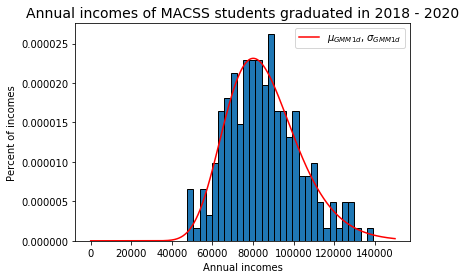

In [19]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_d, scale=np.exp(mu_GMM_1_d)),
        label='$\mu_{GMM1d}$, $\sigma_{GMM1d}$', color='r')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

### (e)

In [20]:
# Define a function returning the error matrix
# To make the error matrix and error vector consistent, I modify Dr. Evans' code so that the difference is 
# calculated by moments of model minus data instead of by moments of data minus model if simple and by moments of
# model minus data over moments of data instead of by moments of data minus model over moments of model if not simple
# since now moments of data can be zero, I could only use the simple method to yield the result.
def get_Err_mat_1_e(pts, mu, sigma, simple=True):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    bpct_1_model, bpct_2_model, bpct_3_model = model_moments_1_de(mu, sigma)
    if simple:
        pts_in_bpct_1 = pts < 75000
        Err_mat[0, :] = bpct_1_model - pts_in_bpct_1
        pts_in_bpct_2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = bpct_2_model - pts_in_bpct_2  
        pts_in_bpct_3 = pts >= 100000
        Err_mat[2, :] = bpct_3_model - pts_in_bpct_3 
    else:
        pts_in_bpct_1 = pts < 75000
        Err_mat[0, :] = (bpct_1_model - pts_in_bpct_1) / pts_in_bpct_1
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (bpct_2_model - pts_in_bpct_2) / pts_in_bpct_2
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (bpct_3_model - pts_in_bpct_3) / pts_in_bpct_3
    
    return Err_mat

In [21]:
# Generate the error matrix and report it
Err_mat_1_e = get_Err_mat_1_e(incomes_1, mu_GMM_1_d, sig_GMM_1_d, simple=True)
VCV_1_e = (1 / incomes_1.shape[0]) * (Err_mat_1_e @ Err_mat_1_e.T)
print('The variance covariance matrix from part (d) is\n', VCV_1_e)
W_hat_1_e = lin.pinv(VCV_1_e)
print('The two-step weighting matrix is\n', W_hat_1_e)

The variance covariance matrix from part (d) is
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
The two-step weighting matrix is
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [22]:
# Two-step GMM estimation and result report
mu_init_1_e = 11
sig_init_1_e = 0.5
params_init_1_e = np.array([mu_init_1_e, sig_init_1_e])
gmm_args_1_e = (incomes_1, W_hat_1_e)
results_1_e = opt.minimize(criterion_1_de, params_init_1_e, args=(gmm_args_1_e),
                           tol=1e-14, method='L-BFGS-B',
                           bounds=((1e-10, None), (1e-10, None)))
mu_GMM_1_e, sig_GMM_1_e = results_1_e.x
crit_val_GMM_1_e = results_1_e.fun
bpct_1_model_GMM_1_e, bpct_2_model_GMM_1_e, bpct_3_model_GMM_1_e = model_moments_1_de(mu_GMM_1_e, sig_GMM_1_e)

print('The two-step GMM estimation of mu is', mu_GMM_1_e)
print('The two-step GMM estimation of sigma is', sig_GMM_1_e)
print('The value of the criterion function at two-step GMM estimates is', crit_val_GMM_1_e)
print('The percent of students earning less than $75,000 in the data is', bpct_1_data_1_de)
print('The percent of students earning less than $75,000 in the model is', bpct_1_model_GMM_1_e)
print('The difference between them is', abs(bpct_1_data_1_de - bpct_1_model_GMM_1_e))
print('The percent difference between them is', abs(bpct_1_data_1_de - bpct_1_model_GMM_1_e) / bpct_1_data_1_de)
print('The percent of students earning between $75,000 and $100,000 in the data is', bpct_2_data_1_de)
print('The percent of students earning between $75,000 and $100,000 in the model is', bpct_2_model_GMM_1_e)
print('The difference between them is', abs(bpct_2_data_1_de - bpct_2_model_GMM_1_e))
print('The percent difference between them is', abs(bpct_2_data_1_de - bpct_2_model_GMM_1_e) / bpct_2_data_1_de)
print('The percent of students earning more than $100,000 in the data is', bpct_3_data_1_de)
print('The percent of students earning more than $100,000 in the model is', bpct_3_model_GMM_1_e)
print('The difference between them is', abs(bpct_3_data_1_de - bpct_3_model_GMM_1_e))
print('The percent difference between them is', abs(bpct_3_data_1_de - bpct_3_model_GMM_1_e) / bpct_3_data_1_de)

The two-step GMM estimation of mu is 11.335681326874862
The two-step GMM estimation of sigma is 0.21059845272390085
The value of the criterion function at two-step GMM estimates is 8.045151642958581e-16
The percent of students earning less than $75,000 in the data is 0.3
The percent of students earning less than $75,000 in the model is 0.3000000036775762
The difference between them is 3.6775761880214475e-09
The percent difference between them is 1.2258587293404826e-08
The percent of students earning between $75,000 and $100,000 in the data is 0.5
The percent of students earning between $75,000 and $100,000 in the model is 0.5000000076556864
The difference between them is 7.655686418139851e-09
The percent difference between them is 1.5311372836279702e-08
The percent of students earning more than $100,000 in the data is 0.2
The percent of students earning more than $100,000 in the model is 0.1999999886667374
The difference between them is 1.1333262606161298e-08
The percent difference bet

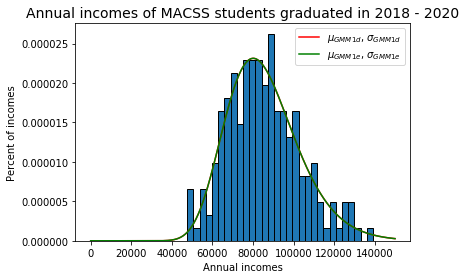

In [23]:
# Draw the lognormal distribution and the histogram
pts = np.linspace(1e-10, 150000, 50000)
ax = plt.gca()
ax.hist(incomes_1, num_bins, density=True, edgecolor='k')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_d, scale=np.exp(mu_GMM_1_d)),
        label='$\mu_{GMM1d}$, $\sigma_{GMM1d}$', color='r')
ax.plot(pts, sts.lognorm.pdf(pts, s=sig_GMM_1_e, scale=np.exp(mu_GMM_1_e)),
        label='$\mu_{GMM1e}$, $\sigma_{GMM1e}$', color='g')
ax.set_title('Annual incomes of MACSS students graduated in 2018 - 2020', fontsize=14)
ax.set_xlabel('Annual incomes')
ax.set_ylabel('Percent of incomes')
plt.legend()
plt.show()

The two lognormal distributions are highly identical, so the green distribution almost cover the red one completely. 

### (f)

The GMM estimations from part (b) to part (e) as well as the corresponding criterion function values are summarized in the following table.

|   | <center>$\mu$</center> | <center>$\sigma$</center> | Criterion Function Value |
| - | ----- | -------- | ------------------------ |
| 2 moments with identity matrix | $11.331881$ | $0.208696$ | $1.005186 \times 10^{-15}$ |
| 2 moments with weighting matrix | $11.331879$ | $0.208705$ | $1.172287 \times 10^{-13}$ |
| 3 moments with identity matrix | $11.335681$ | $0.210598$ | $3.933133 \times 10^{-16}$ |
| 3 moments with weighting matrix | $11.335681$ | $0.210598$ | $8.045152 \times 10^{-16}$ |

It could be found that the GMM estimations are extremely similar to each other, which means the model selection would not affect the accuracy of the estimations to a large extent. Although I list the criterion function value here, it cannot be used to select a best model because the models are estimated either by different moments, or by different distance measures, or by different weighting matrices. To select the best model in application, we should first understand what features of data we are most interested in. For example, if we are interested in the mean and spread of the incomes, we should use the first or second model; if we are interested in the proportion of students in different income ranges, the third or fourth model may do a better job. In terms of whether we should use a weighting matrix, we could compare the difference between the first and second, or the third and fourth model. If they resemble each other, it might not be essential to use the weighting matrix to eliminate potential inaccuracies.

## 2. Linear regression and GMM (3 points)

### (a)

In [24]:
# Import data
df_2 = pd.read_csv('data/sick.txt').astype('float64')
df_2.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [25]:
# Define a function returning the error vector
def err_vec_2(df, b0, b1, b2, b3):
    
    err_vec = df['sick'] - b0 - b1 * df['age'] - b2 * df['children'] - b3 * df['avgtemp_winter'] 
    
    return err_vec

In [26]:
# Define the criterion function
def criterion_2(params, *args):
    
    b0, b1, b2, b3 = params
    df, W = args
    err = err_vec_2(df, b0, b1, b2, b3) 
    crit_val = err.T @ W @ err
    
    return crit_val

In [27]:
# GMM estimation and result report
b0_init_2 = 0.25
b1_init_2 = 0.01
b2_init_2 = 0.4
b3_init_2 = -0.01
params_init_2 = np.array([b0_init_2, b1_init_2, b2_init_2, b3_init_2])
gmm_args_2 = (df_2, np.eye(200))
results_2 = opt.minimize(criterion_2, params_init_2, args=(gmm_args_2), method='L-BFGS-B', tol=1e-14)
b0_GMM_2, b1_GMM_2, b2_GMM_2, b3_GMM_2 = results_2.x
crit_val_GMM_2 = results_2.fun
print('The GMM estimation of beta0 is', b0_GMM_2)
print('The GMM estimation of beta1 is', b1_GMM_2)
print('The GMM estimation of beta2 is', b2_GMM_2)
print('The GMM estimation of beta3 is', b3_GMM_2)
print('The criterion function value at GMM estimates is', crit_val_GMM_2)

The GMM estimation of beta0 is 0.2516442911513447
The GMM estimation of beta1 is 0.012933499171179115
The GMM estimation of beta2 is 0.4005007485856042
The GMM estimation of beta3 is -0.009991714278855665
The criterion function value at GMM estimates is 0.0018212897348736509
